# CNN for TFBS predictions and model interpretability

Training a CNN model on DNA data including binding sites for TF proteins!
The goal is to make predictions for Transcription Factor Binding Sites (TFBS).

## Loading Libraries

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np

from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.core import Dense, Flatten
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import roc_curve, auc, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

## Load the sequence data

In [ ]:
input_fasta_data = pd.read_table("TFBS_sequences_a.txt", header=None)
input_fasta_data.rename(columns={0: "sequence"}, inplace=True)
sequence_length = len(input_fasta_data.sequence[0])
print(sequence_length)

50


In [ ]:
input_fasta_data.head()

,sequence
0,CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...
1,GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...
2,GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...
3,GTCCAAAAGAGGAAGTTCACCTTGACCGCAGAGGTACCACCAGAGC...
4,GGAAAGAGGAAGTTAACTAGAACCTGCATAACTGGCCTGGGAGATA...


## Label - One hot encoding

In [ ]:
lec = LabelEncoder()   
ohe = OneHotEncoder(categories='auto')    
seq_matrix = [] 
for sequence in input_fasta_data.sequence: 
  lecd = lec.fit_transform(list(sequence)) 
  lecd = np.array(lecd).reshape(-1, 1) 
  
  ohed = ohe.fit_transform(lecd)
  seq_matrix.append(ohed.toarray())
seq_matrix = np.stack(seq_matrix)
print(seq_matrix.shape)

(2000, 50, 4)


## Target labels

In [ ]:
labels = pd.read_csv('TFBS_labels.txt')
Y = np.array(labels).reshape(-1) 
print(Y.shape)


(2000,)


### Distribution of Positive and Negative samples

In [ ]:
print(pd.DataFrame(Y).value_counts())

0    1013
1     987
dtype: int64


# Train-test split


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(seq_matrix, Y, test_size=0.25, random_state=42, shuffle=True) 
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

print(X_train.shape)
print(Y_train.shape)

(1500, 50, 4)
(1500,)


In [ ]:
# Reshaping the data to correspond to the input format 
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))
print(X_train.shape, X_train_reshaped.shape)
print(X_test.shape, X_test_reshaped.shape)

(1500, 50, 4) (1500, 50, 4, 1)
(500, 50, 4) (500, 50, 4, 1)


## Create a simple CNN model

In [ ]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=12, input_shape=(50, 4)))
model.add(MaxPooling1D(pool_size=4))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 39, 32)            1568      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 9, 32)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 288)               0         
                                                                 
 dense (Dense)               (None, 16)                4624      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 6,209
Trainable params: 6,209
Non-trainable params: 0
______________________________________________________

# Fit the model

In [ ]:
history = model.fit(X_train_reshaped, Y_train,
          batch_size=10, epochs=10,
          validation_split=0.1)

Epoch 1/10
135/135 [==============================] - 1s 5ms/step - loss: 0.1932 - val_loss: 0.1461
Epoch 2/10
135/135 [==============================] - 0s 4ms/step - loss: 0.1142 - val_loss: 0.1193
Epoch 3/10
135/135 [==============================] - 0s 4ms/step - loss: 0.0808 - val_loss: 0.0827
Epoch 4/10
135/135 [==============================] - 1s 4ms/step - loss: 0.0515 - val_loss: 0.0643
Epoch 5/10
135/135 [==============================] - 0s 3ms/step - loss: 0.0302 - val_loss: 0.0443
Epoch 6/10
135/135 [==============================] - 0s 3ms/step - loss: 0.0189 - val_loss: 0.0337
Epoch 7/10
135/135 [==============================] - 0s 3ms/step - loss: 0.0126 - val_loss: 0.0277
Epoch 8/10
135/135 [==============================] - 0s 3ms/step - loss: 0.0098 - val_loss: 0.0235
Epoch 9/10
135/135 [==============================] - 0s 4ms/step - loss: 0.0054 - val_loss: 0.0227
Epoch 10/10
135/135 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 0.0196

# Visualization

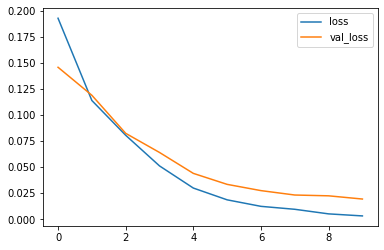

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])

## Evaluating the Model

Using metrics as AUC and AUPRC

In [ ]:
# Model predictions
pred = model.predict(X_test_reshaped, batch_size=32).flatten()

16/16 [==============================] - 0s 2ms/step


In [ ]:
fpr, tpr, thresholds = roc_curve(Y_test, pred)
print("AUC", auc(fpr, tpr))
print("AUPRC", average_precision_score(Y_test, pred))

AUC 0.9984139444720358
AUPRC 0.9983588601815832
